In [1]:
import tensorflow as tf
import pickle
import os
import pandas as pd
import re
import time
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import cv2
import math
# Config the matlotlib backend as plotting inline in IPython
%matplotlib inline

## Utility methods

In [2]:
def show_frames(frames):

    plt.ion() # turn on interactive mode

    for frame in frames:

        plt.figure()
        plt.imshow(frame / 255.0)
        plt.show()
        #_ = raw_input("Press [enter] to continue.")
        plt.close()    # close the figure to show the next one.

def load_images(pickle_file):

    bytes_in = bytearray(0)
    input_size = os.path.getsize(pickle_file)

    with open(pickle_file, 'rb') as f_in:

        max_bytes = 2**31 - 1

        for _ in range(0, input_size, max_bytes):
            bytes_in += f_in.read(max_bytes)

        return pickle.loads(bytes_in)

## Load images and steering angles

In [3]:
center_images = load_images('data/center_camera@120x160.pickle')
print(center_images.shape)

(15212, 120, 160, 3)


(15212,)
-0.0506360505839 0.520000393847


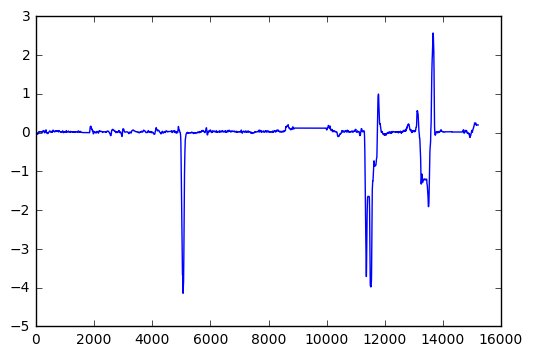

In [4]:
center_steering = pd.read_csv('data/center_steering.csv')['steering_angle'].values
print(center_steering.shape)
print(center_steering.mean(), center_steering.std())
plt.plot(center_steering)

## Removing sharp turns

In [115]:
# removing "stopped" or very low speed frames
# TODO: use speed info

(13866,)


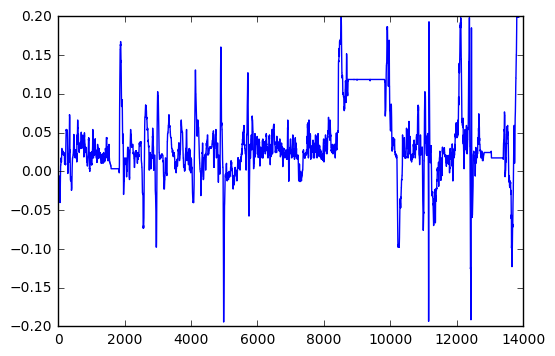

In [5]:
# removing "outliers"
#filtered_center_steering_idx = (abs(center_steering - np.mean(center_steering)) < .3 * np.std(center_steering))
filtered_center_steering_idx = abs(center_steering) < 0.2
center_filtered = center_steering[filtered_center_steering_idx]
#center_images = center_images[filtered_center_steering_idx, ...]
print(center_filtered.shape)
plt.plot(center_filtered)

In [6]:
center_images = center_images[filtered_center_steering_idx, ...]
center_steering = center_filtered

## Scaling, Distortion, Augmentation

In [7]:
PIXEL_DEPTH = 255.0

# Values are rescaled from [0, 255] down to [-0.5, 0.5].
# from https://github.com/tensorflow/tensorflow/blob/master/tensorflow/models/image/mnist/convolutional.py

center_images = (center_images - (PIXEL_DEPTH / 2.0)) / PIXEL_DEPTH

# augmentation should be implemented at this point...

## Train / validation split

In [8]:
traning_size = round(center_images.shape[0] * 0.7)

train_data = center_images[:traning_size,:,:,:]
train_labels = center_steering[:traning_size]
valid_data = center_images[traning_size:,:,:,:]
valid_labels = center_steering[traning_size:]
print(train_data.shape, valid_data.shape)

(9706, 120, 160, 3) (4160, 120, 160, 3)


## Model definition
Based on [End to End Learning for Self-Driving Cars](https://arxiv.org/pdf/1604.07316.pdf)

In [12]:
# Global constants
NUM_CLASSES = 1

# Constants describing the training process.
#MOVING_AVERAGE_DECAY = 0.9999     # The decay to use for the moving average.
#NUM_EPOCHS_PER_DECAY = 350.0      # Epochs after which learning rate decays.
#LEARNING_RATE_DECAY_FACTOR = 0.1  # Learning rate decay factor.
#INITIAL_LEARNING_RATE = 0.1       # Initial learning rate.

def weight_variable(shape, std=0.1):
    initial = tf.truncated_normal(shape, stddev=std)
    return tf.Variable(initial)

def bias_variable(shape, value=0.):
    initial = tf.constant(value, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W, stride):
    return tf.nn.conv2d(x, W, strides=[1, stride, stride, 1], padding='VALID')

def inputs(batch_size):
    """Construct input
    Returns:
    images: Images. 4D tensor of [batch_size, IMAGE_SIZE, IMAGE_SIZE, 3] size.
    labels: Labels. 1D tensor of [batch_size] size.
    """
    
    tf_images = tf.placeholder(tf.float32, shape=(batch_size, center_images.shape[1], 
                                                         center_images.shape[2], center_images.shape[3]))
    tf_labels = tf.placeholder(tf.float32, shape=(batch_size))
    
    # Subtract off the mean and divide by the variance of the pixels.
    #distorted_images = tf.image.per_image_whitening(tf_train_dataset)
    
    return tf_images, tf_labels

def inference(images):
    """Build End-to-End Deep Learning for Self-Driving Cars model.
    Args:
    images: Images returned from distorted_inputs().
    Returns:
    Steering angle.
    """
    
    # conv1
    with tf.variable_scope('conv1') as scope:
        kernel = weight_variable([5, 5, 3, 24])
        conv = conv2d(images, kernel, 2)
        bias = bias_variable([24])
        conv1 = tf.nn.relu(conv + bias, name=scope.name)
        #_activation_summary(conv1)

    # pool1
    #pool1 = tf.nn.max_pool(conv1, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1],
    #                       padding='SAME', name='pool1')
    # norm1
    #norm1 = tf.nn.lrn(pool1, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75,
    #                  name='norm1')

    # conv2
    with tf.variable_scope('conv2') as scope:
        kernel = weight_variable([5, 5, 24, 36])
        conv = conv2d(conv1, kernel, 2)
        bias = bias_variable([36])
        conv2 = tf.nn.relu(conv + bias, name=scope.name)
        #_activation_summary(conv2)

    # conv3
    with tf.variable_scope('conv3') as scope:
        kernel = weight_variable([5, 5, 36, 48])
        conv = conv2d(conv2, kernel, 2)
        bias = bias_variable([48])
        conv3 = tf.nn.relu(conv + bias, name=scope.name)
        #_activation_summary(conv3)
        
    # conv4
    with tf.variable_scope('conv4') as scope:
        kernel = weight_variable([3, 3, 48, 64])
        conv = conv2d(conv3, kernel, 1)
        bias = bias_variable([64])
        conv4 =tf.nn.relu(conv + bias, name=scope.name)
        #_activation_summary(conv4)
        
    # conv5
    with tf.variable_scope('conv5') as scope:
        kernel = weight_variable([3, 3, 64, 64])
        conv = conv2d(conv4, kernel, 1)
        bias = bias_variable([64])
        conv5 = tf.nn.relu(conv + bias, name=scope.name)
        #_activation_summary(conv5)

    # fully1
    with tf.variable_scope('fully1') as scope:
        # Move everything into depth so we can perform a single matrix multiply.
        reshape = tf.reshape(conv5, [conv5.get_shape().as_list()[0], -1])
        dim = reshape.get_shape()[1].value
        weights = weight_variable([dim, 100])
        bias = bias_variable([100])
        fully1 = tf.nn.relu(tf.matmul(reshape, weights) + bias, name=scope.name)
        fully1_drop = tf.nn.dropout(fully1, keep_prob)
        
        weight_decay = tf.mul(tf.nn.l2_loss(weights),1e-2, name='weight_loss')
        bias_decay = tf.mul(tf.nn.l2_loss(bias), 1e-2, name='bias_loss')
        tf.add_to_collection('losses', weight_decay)
        tf.add_to_collection('losses', bias_decay)
        #_activation_summary(fully1)
        
    # fully2
    with tf.variable_scope('fully2') as scope:
        weights = weight_variable([100, 50])
        bias = bias_variable([50])
        fully2 = tf.nn.relu(tf.matmul(fully1, weights) + bias, name=scope.name)
        #_activation_summary(fully2)
        fully2_drop = tf.nn.dropout(fully2, keep_prob)
        
        weight_decay = tf.mul(tf.nn.l2_loss(weights), 1e-2, name='weight_loss')
        bias_decay = tf.mul(tf.nn.l2_loss(bias),1e-2, name='bias_loss')
        tf.add_to_collection('losses', weight_decay)
        tf.add_to_collection('losses', bias_decay)
        
    # fully3
    with tf.variable_scope('fully3') as scope:
        weights = weight_variable([50, 10])
        bias = bias_variable([10])
        fully3 = tf.nn.relu(tf.matmul(fully2, weights) + bias, name=scope.name)
        #_activation_summary(fully3)
        fully3_drop = tf.nn.dropout(fully3, keep_prob)
        
        weight_decay = tf.mul(tf.nn.l2_loss(weights), 1e-2, name='weight_loss')
        bias_decay = tf.mul(tf.nn.l2_loss(bias), 1e-2, name='bias_loss')
        tf.add_to_collection('losses', weight_decay)
        tf.add_to_collection('losses', bias_decay)
  
    # output
    with tf.variable_scope('output') as scope:
        weights = weight_variable([10, NUM_CLASSES])
        bias = bias_variable([NUM_CLASSES])
        #output = tf.add(tf.matmul(fully3_drop, weights), bias, name=scope.name)
        output = tf.mul(tf.tanh(tf.matmul(fully3_drop, weights) + bias), 1.0)
        weight_decay = tf.mul(tf.nn.l2_loss(weights), 1e-2, name='weight_loss')
        bias_decay = tf.mul(tf.nn.l2_loss(bias), 1e-2, name='bias_loss')
        tf.add_to_collection('losses', weight_decay)
        tf.add_to_collection('losses', bias_decay)
        #_activation_summary(output)

    return output
    
def get_loss(logits, labels):
    """Add L2Loss to all the trainable variables.
    Add summary for "Loss" and "Loss/avg".
    Args:
    logits: Logits from inference().
    labels: Labels from distorted_inputs or inputs(). 1-D tensor
            of shape [batch_size]
    Returns:
    Loss tensor of type float.
    """
    
    mse = tf.reduce_mean(tf.square(tf.sub(logits, labels)))
    #mse = tf.contrib.metrics.get(logits, labels)
    tf.add_to_collection('losses', mse)
    
    # The total loss is defined as the cross entropy loss plus all of the weight
    # decay terms (L2 loss).
    return tf.add_n(tf.get_collection('losses'), name='total_loss')
    #return mse

## Build Graph

In [13]:
batch_size = 128

graph = tf.Graph()
with graph.as_default():
    
    keep_prob = tf.placeholder(tf.float32)
    
    images, labels = inputs(batch_size)

    logits = inference(images)

    # Training computation.
    loss = get_loss(logits, labels)

    # Optimizer.
    #optimizer = tf.train.GradientDescentOptimizer(0.01).minimize(loss)
    optimizer = tf.train.AdamOptimizer(1e-4).minimize(loss)

## Training

Initialized
2016-10-12 21:47:39.681366: step 0, duration = 3.874 (3.874)
Minibatch error at step 0: 3.064447
Validation error at step 0: 0.351874
Model saved in file: ./train/model.ckpt


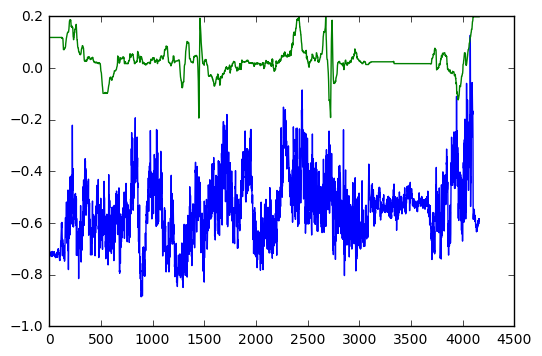

2016-10-12 21:48:12.879684: step 50, duration = 0.574 (30.266)
Minibatch error at step 50: 2.464138
Validation error at step 50: 0.003741
2016-10-12 21:48:44.703492: step 100, duration = 0.527 (56.330)
Minibatch error at step 100: 2.330416
Validation error at step 100: 0.003226
2016-10-12 21:49:15.985880: step 150, duration = 0.528 (82.220)
Minibatch error at step 150: 2.199074
Validation error at step 150: 0.003139
2016-10-12 21:49:50.661421: step 200, duration = 0.558 (111.336)
Minibatch error at step 200: 2.072307
Validation error at step 200: 0.003038
Model saved in file: ./train/model.ckpt


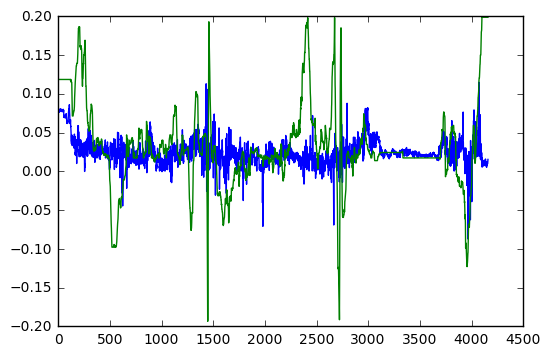

2016-10-12 21:50:26.195391: step 250, duration = 0.551 (139.174)
Minibatch error at step 250: 1.951752
Validation error at step 250: 0.003067
2016-10-12 21:50:59.358622: step 300, duration = 0.540 (166.595)
Minibatch error at step 300: 1.835921
Validation error at step 300: 0.002995
2016-10-12 21:51:32.507653: step 350, duration = 0.540 (194.011)
Minibatch error at step 350: 1.726962
Validation error at step 350: 0.002993
2016-10-12 21:52:06.261454: step 400, duration = 0.550 (221.959)
Minibatch error at step 400: 1.623496
Validation error at step 400: 0.002971
Model saved in file: ./train/model.ckpt


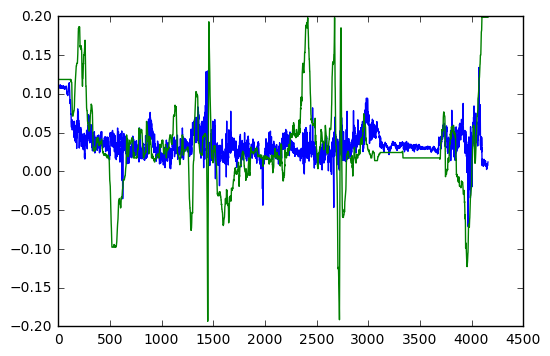

2016-10-12 21:52:41.808958: step 450, duration = 0.565 (250.141)
Minibatch error at step 450: 1.525235
Validation error at step 450: 0.002923
2016-10-12 21:53:15.531232: step 500, duration = 0.566 (277.992)
Minibatch error at step 500: 1.432526
Validation error at step 500: 0.002938
2016-10-12 21:53:53.523805: step 550, duration = 0.702 (309.832)
Minibatch error at step 550: 1.345217
Validation error at step 550: 0.002900
2016-10-12 21:54:31.923595: step 600, duration = 0.676 (341.563)
Minibatch error at step 600: 1.262856
Validation error at step 600: 0.002914
Model saved in file: ./train/model.ckpt


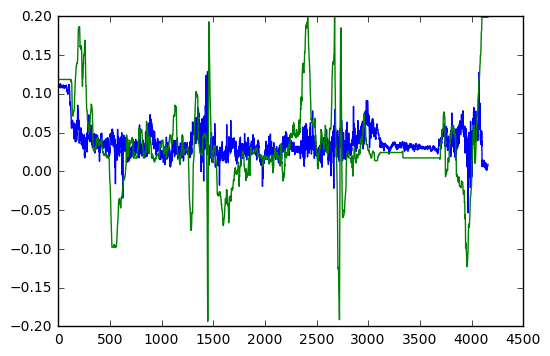

2016-10-12 21:55:07.734681: step 650, duration = 0.551 (369.743)
Minibatch error at step 650: 1.184863
Validation error at step 650: 0.002912
2016-10-12 21:55:43.593258: step 700, duration = 0.597 (399.839)
Minibatch error at step 700: 1.111429
Validation error at step 700: 0.002891
2016-10-12 21:56:20.227895: step 750, duration = 0.661 (429.973)
Minibatch error at step 750: 1.042779
Validation error at step 750: 0.002947
2016-10-12 21:56:56.750232: step 800, duration = 0.597 (460.044)
Minibatch error at step 800: 0.977383
Validation error at step 800: 0.002913
Model saved in file: ./train/model.ckpt


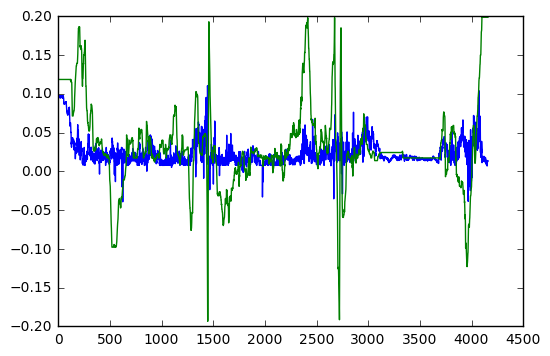

2016-10-12 21:57:35.214329: step 850, duration = 0.614 (490.637)
Minibatch error at step 850: 0.916291
Validation error at step 850: 0.002913
2016-10-12 21:58:11.195425: step 900, duration = 0.603 (520.486)
Minibatch error at step 900: 0.859123
Validation error at step 900: 0.002984
2016-10-12 21:58:49.366043: step 950, duration = 0.661 (552.067)
Minibatch error at step 950: 0.804436
Validation error at step 950: 0.002899
2016-10-12 21:59:26.340876: step 1000, duration = 0.582 (582.224)
Minibatch error at step 1000: 0.753745
Validation error at step 1000: 0.002916
Model saved in file: ./train/model.ckpt


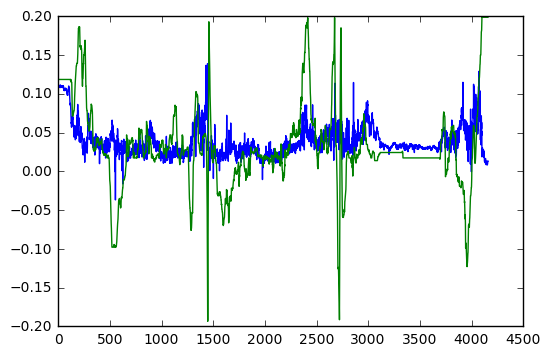

2016-10-12 21:59:33.852188: across 1001 steps, 0.582 +/- 0.113 sec / batch


In [14]:
from sklearn.metrics import mean_squared_error
num_steps = 1001
LOGDIR = './train'

# Small utility function to evaluate a dataset by feeding batches of data to
# {eval_data} and pulling the results from {eval_predictions}.
# Saves memory and enables this to run on smaller GPUs.
def eval_in_batches(data, sess):
    """Get all predictions for a dataset by running it in small batches."""
    size = data.shape[0]
    
    if size < batch_size:
        raise ValueError("batch size for evals larger than dataset: %d" % size)
    predictions = np.ndarray(shape=(size, NUM_CLASSES), dtype=np.float32)
    
    for begin in range(0, size, batch_size):
        end = begin + batch_size
        
        if end <= size:
            predictions[begin:end, :] = sess.run(logits, feed_dict={images: data[begin:end, ...], keep_prob: 1.0})
        else:
            batch_predictions = sess.run(logits, feed_dict={images: data[-batch_size:, ...], keep_prob: 1.0})
            predictions[begin:, :] = batch_predictions[begin - size:]
        
    return np.reshape(predictions, size)

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print('Initialized')
    
    saver = tf.train.Saver()
  

    total_duration = 0.0
    total_duration_squared = 0.0

    for step in range(num_steps):
        
        start_time = time.time()
    
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_data[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size)]
        feed_dict = {images: batch_data, labels: batch_labels, keep_prob: 0.8}
        _, l, pred = session.run([optimizer, loss, logits], feed_dict=feed_dict)
        
        duration = time.time() - start_time
        
        total_duration += duration
        total_duration_squared += duration * duration
        
        if (step % 50 == 0):
            
            print ('%s: step %d, duration = %.3f (%.3f)' % (datetime.now(), step, duration, total_duration))
            print('Minibatch error at step %d: %f' % (step, l))
            eval_pred = eval_in_batches(valid_data, session)
            print('Validation error at step %d: %f' % (step, mean_squared_error(eval_pred, valid_labels)))
            
        if (step % 200 == 0):    
            
            if not os.path.exists(LOGDIR):
                os.makedirs(LOGDIR)
            checkpoint_path = os.path.join(LOGDIR, "model.ckpt")
            filename = saver.save(session, checkpoint_path)
            print("Model saved in file: %s" % filename)
            
            plt.plot(eval_pred, label='eval')
            plt.plot(valid_labels, label='truth')
            plt.show()
    
    mn = total_duration / num_steps
    vr = total_duration_squared / num_steps - mn * mn
    sd = math.sqrt(vr)
    print ('%s: across %d steps, %.3f +/- %.3f sec / batch' % (datetime.now(), num_steps, mn, sd))